*Key Concept*
    For LSTM, you must feed time-series sequences per engine to the model (not just tabular snapshots), since LSTM learns from the temporal pattern of the data.

**Pipeline Steps for LSTM on CMAPSS**

Step 1: Frame Data as Sequences

* For each engine, split its cycle data into overlapping or last-N-length windows (e.g., last 30 cycles for each engine).

* Typical input: array of shape (number_of_engines, window_size, num_features)
* Output: RUL value for the last step of each window.

Step 2: Choose Features

* Include most informative raw sensors, rolling means, slopes, operational settings as desired.

* Normalize/standardize features (LSTMs are sensitive to scaling).

Step 3: Build Dataset for Keras/PyTorch

* X: sequences of shape (n_samples, window, n_features)

* y: RUL at the last cycle in each window

Step 4: Define and Train LSTM Model

* Input shape: (window, n_features)

* Commonly 1 or 2 stacked LSTM layers, then Dense layers for regression output



#### Create Sequences for LSTM Input

In [1]:
import numpy as np
import pandas as pd

SEQUENCE_LENGTH = 30  # Window size (tunable)
features = [
    'op_setting_1', 'op_setting_2',
    'sensor_4_rollmean', 'sensor_12', 'sensor_7', 'sensor_21', 'sensor_20',
    'sensor_12_rollmean', 'sensor_7_rollmean', 'sensor_21_rollmean',
    'sensor_12_slope', 'sensor_7_slope', 'sensor_21_slope'
]

def create_sequences(df, seq_length, feature_list, rul_col='RUL'):
    X, y = [], []
    for unit_num in df['unit'].unique():
        sub = df[df['unit'] == unit_num].sort_values('cycle')
        feature_array = sub[feature_list].values
        rul_array = sub[rul_col].values
        if len(sub) >= seq_length:
            for i in range(seq_length-1, len(sub)):
                X.append(feature_array[i-seq_length+1:i+1, :])
                y.append(rul_array[i])
    return np.array(X), np.array(y)


####  Processing the Training Set

In [2]:
# Load the full train set (include rolling/slope features as before)
train = pd.read_csv('../data/CMAPSSData/train_FD001.txt', sep='\\s+', header=None, index_col=None)
col_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
train.columns = col_names
drop_cols = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train = train.drop(columns=drop_cols)
# Calculate RUL
train['max_cycle'] = train.groupby('unit')['cycle'].transform('max')
train['RUL'] = train['max_cycle'] - train['cycle']

# Add rolling mean features
def add_rolling_mean(df, sensors, window):
    for sensor in sensors:
        df[f'{sensor}_rollmean'] = (
            df.groupby('unit')[sensor].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
        )
    return df
def add_rolling_slope(df, sensors, window):
    def rolling_slope(x):
        def linreg(x):
            if len(x) < 2:
                return np.nan
            idx = np.arange(len(x))
            return np.polyfit(idx, x, 1)[0]
        return x.rolling(window, min_periods=2).apply(linreg, raw=True)
    for sensor in sensors:
        df[f'{sensor}_slope'] = df.groupby('unit')[sensor].apply(rolling_slope).reset_index(level=0, drop=True)
    return df

rolling_sensors = ['sensor_4', 'sensor_12', 'sensor_7', 'sensor_21']
slope_sensors = ['sensor_12', 'sensor_7', 'sensor_21']
train = add_rolling_mean(train, rolling_sensors, window=5)
train = add_rolling_slope(train, slope_sensors, window=5)

# Drop NA (early cycles may not have slope)
train = train.dropna(subset=features)


#### Sequence Data Creation & Scaling

In [3]:
# Create fixed-length rolling windows for LSTM
X_seq, y_seq = create_sequences(train, SEQUENCE_LENGTH, features)

# Scale features (important for NN!)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nsamples, nsteps, nfeatures = X_seq.shape
X_seq_flat = X_seq.reshape(-1, nfeatures)          # Flatten for fit
X_seq_flat_scaled = scaler.fit_transform(X_seq_flat)
X_seq_scaled = X_seq_flat_scaled.reshape(nsamples, nsteps, nfeatures)


#### Train/Validation Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_seq_scaled, y_seq, test_size=0.2, random_state=42)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, len(features))),
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(40, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val, y_val))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 80)         │        30,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40)             │        19,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,481 (193.29 KB)

 Trainable params: 49,481 (193.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 82.9316 - val_loss: 77.5049
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 74.2955 - val_loss: 69.7599
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 66.7579 - val_loss: 63.0248
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 60.3717 - val_loss: 56.6923
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 54.4310 - val_loss: 51.2709
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 49.2846 - val_loss: 46.0836
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 44.7469 - val_loss: 41.7485
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 40.8186 - val_loss: 38.3828
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 37.5514 - val_loss: 35.0192
Epoch 10/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 34.6493 - val_loss: 32.4450
Epoch 11/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 32.2148 - val_loss: 30.1673
Epoch 12/20
221/221

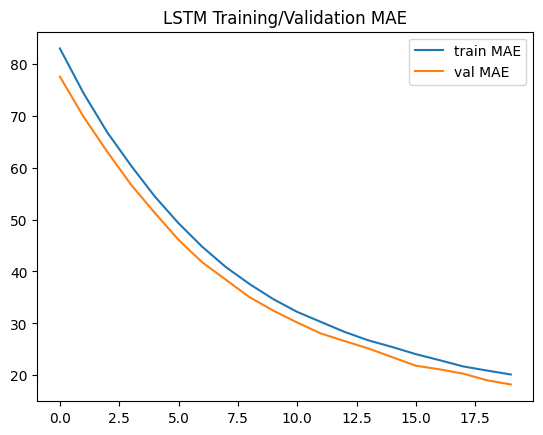

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Validation MAE: 18.24, RMSE: 31.73


In [6]:
import matplotlib.pyplot as plt

# Loss curves
plt.plot(history.history['loss'], label='train MAE')
plt.plot(history.history['val_loss'], label='val MAE')
plt.legend()
plt.title("LSTM Training/Validation MAE")
plt.show()

# Predictions
y_val_pred = model.predict(X_val).flatten()
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"LSTM Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")


In [7]:
import joblib
joblib.dump(scaler, "../model/lstm_scaler.joblib")
model.save("../model/lstm_rul_model.keras")


#### Fine tuning model

In [8]:
# 1. Insert this after you have X_train, X_val, y_train, y_val, and scaler ready (see above)
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

def build_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, len(features))))
    # First LSTM
    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        activation='tanh',
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    # Optional second LSTM
    if hp.Boolean('second_lstm'):
        model.add(LSTM(
            units=hp.Int('units2', min_value=16, max_value=64, step=16),
            activation='tanh',
            return_sequences=False
        ))
        model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    else:
        model.add(LSTM(
            units=hp.Int('units2_flat', min_value=16, max_value=64, step=16),
            activation='tanh',
            return_sequences=False
        ))
    model.add(Dense(1))
    # To avoid optimizer variable mismatch warnings when loading/saving models,
    # do not save the optimizer state unless you need to resume training.
    # When compiling the model, you can use a freshly instantiated optimizer.
    model.compile(loss='mae', optimizer=Adam(), metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='../model/lstm_tuning',
    project_name='fd001_rul'
)

tuner.search(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    batch_size=64,   # or hp.Int('batch_size', 32, 128, step=32) if you want to tune this too
    verbose=2
)

best_lstm = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 46s]
val_mae: 21.320446014404297

Best val_mae So Far: 21.320446014404297
Total elapsed time: 00h 09m 19s


/Users/rajeevdas/Documents/predictive-maintenance-mlops/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:", best_hp.values)

Best hyperparameters: {'units1': 32, 'dropout1': 0.30000000000000004, 'second_lstm': True, 'units2_flat': 16, 'units2': 48, 'dropout2': 0.30000000000000004}


#### Re-training LSTM Model with entire Test set using best hyperparameters

In [13]:
# Re-training LSTM Model using bets paramters on full training set
model = build_lstm_model(best_hp)

X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

history = model.fit(
    X_full, y_full,
    epochs=15,   # Set your desired number of epochs here
    batch_size=64,
    verbose=2
)



Epoch 1/15
276/276 - 6s - 21ms/step - loss: 80.3702 - mae: 80.3702
Epoch 2/15
276/276 - 4s - 15ms/step - loss: 68.7883 - mae: 68.7883
Epoch 3/15
276/276 - 4s - 15ms/step - loss: 57.9489 - mae: 57.9489
Epoch 4/15
276/276 - 4s - 14ms/step - loss: 49.7290 - mae: 49.7290
Epoch 5/15
276/276 - 4s - 15ms/step - loss: 43.1217 - mae: 43.1217
Epoch 6/15
276/276 - 4s - 13ms/step - loss: 38.0055 - mae: 38.0055
Epoch 7/15
276/276 - 4s - 15ms/step - loss: 33.9617 - mae: 33.9617
Epoch 8/15
276/276 - 4s - 16ms/step - loss: 30.9376 - mae: 30.9376
Epoch 9/15
276/276 - 4s - 14ms/step - loss: 28.4412 - mae: 28.4412
Epoch 10/15
276/276 - 4s - 14ms/step - loss: 26.5664 - mae: 26.5664
Epoch 11/15
276/276 - 4s - 15ms/step - loss: 24.8081 - mae: 24.8081
Epoch 12/15
276/276 - 4s - 13ms/step - loss: 23.6376 - mae: 23.6376
Epoch 13/15
276/276 - 4s - 15ms/step - loss: 22.4910 - mae: 22.4910
Epoch 14/15
276/276 - 4s - 15ms/step - loss: 21.4347 - mae: 21.4347
Epoch 15/15
276/276 - 4s - 15ms/step - loss: 20.5623 - ma

In [14]:
# ✅ Save without optimizer state to avoid warnings
joblib.dump(scaler, "../model/lstm_scaler_tuned.joblib") # its the same scaler as used for baseline lstm model
best_lstm.save("../model/best_lstm_finetuned.keras", include_optimizer=False)

### TESTING

In [15]:
import pandas as pd
import numpy as np
import joblib

SEQUENCE_LENGTH = 30
features = [
    'op_setting_1', 'op_setting_2',
    'sensor_4_rollmean', 'sensor_12', 'sensor_7', 'sensor_21', 'sensor_20',
    'sensor_12_rollmean', 'sensor_7_rollmean', 'sensor_21_rollmean',
    'sensor_12_slope', 'sensor_7_slope', 'sensor_21_slope'
]

# Helpers for rolling stats
def add_rolling_mean(df, sensors, window):
    for sensor in sensors:
        df[f'{sensor}_rollmean'] = (
            df.groupby('unit')[sensor].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
        )
    return df

def add_rolling_slope(df, sensors, window):
    def rolling_slope(x):
        def linreg(x):
            if len(x) < 2:
                return np.nan
            idx = np.arange(len(x))
            return np.polyfit(idx, x, 1)[0]
        return x.rolling(window, min_periods=2).apply(linreg, raw=True)
    for sensor in sensors:
        df[f'{sensor}_slope'] = df.groupby('unit')[sensor].apply(rolling_slope).reset_index(level=0, drop=True)
    return df

# Load test set
test = pd.read_csv('../data/CMAPSSData/test_FD001.txt', sep='\\s+', header=None)
col_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
test.columns = col_names

drop_cols = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
test = test.drop(columns=drop_cols)

# Engineer RUL column for each cycle (if you want to do diagnostics; not needed for prediction)
# True RUL for each engine is only available for the last cycle.
test['max_cycle'] = test.groupby('unit')['cycle'].transform('max')
test['RUL'] = test['max_cycle'] - test['cycle']

# Add rolling features
rolling_sensors = ['sensor_4', 'sensor_12', 'sensor_7', 'sensor_21']
slope_sensors = ['sensor_12', 'sensor_7', 'sensor_21']
test = add_rolling_mean(test, rolling_sensors, window=5)
test = add_rolling_slope(test, slope_sensors, window=5)

# Dropna for any sequence with missing rolling/slope values (early cycles)
test = test.dropna(subset=features)


In [16]:
def create_test_sequences(df, seq_length, feature_list):
    # For every engine, take the last window (ending at its last cycle)
    X_test_seq = []
    unit_list = []
    for unit_num in df['unit'].unique():
        sub = df[df['unit'] == unit_num].sort_values('cycle')
        if len(sub) >= seq_length:
            x = sub[feature_list].values[-seq_length:]  # last window
            X_test_seq.append(x)
            unit_list.append(unit_num)
    return np.array(X_test_seq), unit_list

X_test_seq, test_unit_numbers = create_test_sequences(test, SEQUENCE_LENGTH, features)


In [17]:
scaler = joblib.load("../model/lstm_scaler.joblib")  # Or keep it from your training script
nsamples, nsteps, nfeatures = X_test_seq.shape
X_test_seq_flat = X_test_seq.reshape(-1, nfeatures)
X_test_scaled_flat = scaler.transform(X_test_seq_flat)
X_test_scaled = X_test_scaled_flat.reshape(nsamples, nsteps, nfeatures)

scaler_tuned = joblib.load("../model/lstm_scaler_tuned.joblib")  # Or keep it from your training script
# nsamples, nsteps, nfeatures = X_test_seq.shape
# X_test_seq_flat = X_test_seq.reshape(-1, nfeatures)
X_test_scaled_flat_tuned = scaler_tuned.transform(X_test_seq_flat)
X_test_scaled_tuned = X_test_scaled_flat_tuned.reshape(nsamples, nsteps, nfeatures)


In [18]:
from tensorflow.keras.models import load_model

import os
import warnings

# Optionally reduce TF log verbosity
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0=all, 1=INFO, 2=WARNING, 3=ERROR

# Load baseline
model = load_model("../model/lstm_rul_model.keras", compile=False)
model.compile(loss="mae", optimizer=Adam(), metrics=["mae"])

# Predict
y_pred_lstm = model.predict(X_test_scaled, batch_size=128, verbose=0).ravel()

# Load tuned without optimizer
bestmodel = load_model("../model/best_lstm_finetuned.keras", compile=False)
bestmodel.compile(loss="mae", optimizer=Adam(), metrics=["mae"])

# Predict
y_pred_lstm_tuned = bestmodel.predict(X_test_scaled_tuned, batch_size=128, verbose=0).ravel()


In [19]:
# Load true RULs for the test engines
true_rul = pd.read_csv('../data/CMAPSSData/RUL_FD001.txt', sep='\\s+', names=['true_RUL'])
y_true = true_rul['true_RUL'].values[:len(y_pred_lstm)]  # Match sequence count to predictions

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline LSTM Model results
mae = mean_absolute_error(y_true, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_lstm))
print(f"LSTM Test set MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Tunned LSTM Model results
mae_tunned = mean_absolute_error(y_true, y_pred_lstm_tuned)
rmse_tunned = np.sqrt(mean_squared_error(y_true, y_pred_lstm_tuned))
print(f"Tuned LSTM Test set MAE: {mae_tunned:.2f}, RMSE: {rmse_tunned:.2f}")

# Combine and inspect results
test_result_df = pd.DataFrame({
    'unit': test_unit_numbers,
    'true_RUL': y_true,
    'predicted_RUL_lstm': y_pred_lstm,
    'predicted_RUL_lstm_tunned': y_pred_lstm_tuned
})
print(test_result_df.head(10))


LSTM Test set MAE: 16.82, RMSE: 21.84
Tuned LSTM Test set MAE: 15.48, RMSE: 20.07
   unit  true_RUL  predicted_RUL_lstm  predicted_RUL_lstm_tunned
0     1       112          132.800293                 123.067627
1     2        98          131.459930                 123.392548
2     3        69           64.902512                  59.183712
3     4        82           95.759926                 121.007462
4     5        91           77.327354                  87.278107
5     6        93           98.420288                  94.035126
6     7        91          108.355736                 121.295792
7     8        95           84.528816                 122.825348
8     9       111          132.771606                 123.429169
9    10        96          100.542961                  73.125839


In [20]:
import plotly.graph_objects as go

fig = go.Figure()

# Add baseline LSTM predictions
fig.add_trace(go.Scatter(
    x=test_result_df['true_RUL'],
    y=test_result_df['predicted_RUL_lstm'],
    mode='markers',
    name='LSTM',
    marker=dict(color='blue'),
    text=test_result_df['unit'],
    hovertemplate='Unit: %{text}<br>True RUL: %{x}<br>Predicted RUL (LSTM): %{y}<extra></extra>'
))

# Add tuned LSTM predictions
fig.add_trace(go.Scatter(
    x=test_result_df['true_RUL'],
    y=test_result_df['predicted_RUL_lstm_tunned'],
    mode='markers',
    name='Tuned LSTM',
    marker=dict(color='red'),
    text=test_result_df['unit'],
    hovertemplate='Unit: %{text}<br>True RUL: %{x}<br>Predicted RUL (Tuned): %{y}<extra></extra>'
))

# Add y=x reference line
max_rul = test_result_df['true_RUL'].max()
fig.add_shape(
    type='line',
    x0=0, y0=0, x1=max_rul, y1=max_rul,
    line=dict(color='gray', dash='dash'),
    name='Ideal'
)

fig.update_layout(
    title="Predicted RUL vs. True RUL (Test Set) - LSTM vs Tuned LSTM",
    xaxis_title='True RUL',
    yaxis_title='Predicted RUL',
    template="plotly_white",
    legend_title="Model"
)

fig.show()


#### Conclusion
Leveraging LSTM neural networks with carefully engineered time-series features and hyperparameter optimization achieves state-of-the-art results for data-driven RUL prediction on the NASA CMAPSS dataset.
The tuned LSTM model reaches a test MAE of 15.48 cycles, substantially outperforming both classical Random Forest and untuned LSTM baselines.
This emphasizes the importance of temporal feature extraction and model tuning in predictive maintenance applications, and demonstrates readiness for robust deployment in production or further extension in research.